### 1.通过aesthetics scorer量化模型质量
### 1.aesthetics scorer for image

In [1]:
#API to use txt2img 
#API调用SD文生图
import pandas as pd
import requests
import os

def ImageSET(prompt,negative_prompt='(worst quality, low quality,NSFW:2), EasyNegative ,ng_deepnegative_v1_75t',
             cfg_scale=6,width=512,height=768,sampler_name='DPM++ 2M Karras',seed=1,batch_size=4,n_iter=2,steps=30,enable_hr=True,hr_upscaler="4x-UltraSharp"):
  ImagePayload = {
    "enable_hr": enable_hr,
    "denoising_strength": 0.5,
    "hr_scale": 2,
    "hr_upscaler": hr_upscaler,
    "prompt": prompt,
    "seed": seed,
    "sampler_name": sampler_name,
    "batch_size": batch_size,
    "n_iter": n_iter,
    "steps": steps,
    "cfg_scale": cfg_scale,
    "width": width,
    "height": height,
    "negative_prompt": negative_prompt,
    "save_images": True,
  }
  return ImagePayload

def OptionsSET(sd_model_checkpoint="GhostMix-V2.0-fp16-NoVAE",sd_vae = "vae-ft-mse-840000-ema-pruned.safetensors", outdir_txt2img_samples = "./Image/ImageRating",promptindex=''):
  if len(str(sd_model_checkpoint))*len(str(promptindex)) !=0:
    foldername = str(sd_model_checkpoint)+'-'+str(promptindex)
    outdir_txt2img_samples = os.path.join(outdir_txt2img_samples,foldername)
  OptionsPayload = {
    "sd_model_checkpoint": sd_model_checkpoint,
    "sd_vae": sd_vae,
    "outdir_txt2img_samples": outdir_txt2img_samples
  }
  return OptionsPayload

In [2]:
#API to use txt2img 
#API调用SD文生图
#Get Prompts from PromptsDataFrame
#通过PromptsDataFrame提取出对应的参数

import pandas as pd

PromptDataFrame= pd.read_csv('./PromptsForReviews/PromptsSummaryFromCivitai.csv')
PromptDataFrameNotDone = PromptDataFrame[PromptDataFrame['Skip']!=True]

url = "http://127.0.0.1:7860"

for i in range(len(PromptDataFrameNotDone)):
    temp = PromptDataFrameNotDone.iloc[i].dropna()
    Prompts = temp['Prompts']
    sd_model_checkpoint=temp['sd_model_checkpoint']
    optionsjson = OptionsSET(sd_model_checkpoint=sd_model_checkpoint,promptindex=str(temp['index']))
    imagejson = ImageSET(Prompts,cfg_scale=6,batch_size=4,n_iter=8)
    optionspost = requests.post(url=f'{url}/sdapi/v1/options', json=optionsjson)
    imagepost = requests.post(url=f'{url}/sdapi/v1/txt2img', json=imagejson)
    PromptDataFrame.loc[(PromptDataFrame['index'] == temp['index'])&(PromptDataFrame['sd_model_checkpoint'] == temp['sd_model_checkpoint']),'Skip'] = True
    PromptDataFrame.to_csv('./PromptsForReviews/PromptsSummaryFromCivitai.csv')

In [3]:
#aesthetics scorer for 1 image method 1
#1张图片的美学分数method 1

import sys
sys.path.append("aesthetics-scorer-main")
import torch
from aesthetics_scorer.model import preprocess, load_model
from transformers import CLIPModel, CLIPProcessor

MODEL = "laion/CLIP-ViT-L-14-laion2B-s32B-b82K"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CLIPModel.from_pretrained(MODEL)
vision_model = model.vision_model
vision_model.to(DEVICE)
del model
clip_processor = CLIPProcessor.from_pretrained(MODEL)

rating_model = load_model("aesthetics-scorer-main/aesthetics_scorer/models/aesthetics_scorer_rating_openclip_vit_l_14.pth").to(DEVICE)
artifacts_model = load_model("aesthetics-scorer-main/aesthetics_scorer/models/aesthetics_scorer_artifacts_openclip_vit_l_14.pth").to(DEVICE)

def predict(img):
    inputs = clip_processor(images=img, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        vision_output = vision_model(**inputs)
    pooled_output = vision_output.pooler_output
    embedding = preprocess(pooled_output)
    with torch.no_grad():
        rating = rating_model(embedding)
        artifact = artifacts_model(embedding)
    return rating.detach().cpu().item(), artifact.detach().cpu().item()

In [4]:
#LAION aesthetics scorer for 1 image
#LAION 1张图片的美学分数

import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
import clip
import torch.nn.functional as F

class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            #nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
            x = batch[self.xcol]
            y = batch[self.ycol].reshape(-1, 1)
            x_hat = self.layers(x)
            loss = F.mse_loss(x_hat, y)
            return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def normalized(a, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def PredictionLAION(image):
    model = MLP(768)  # CLIP embedding dim is 768 for CLIP ViT L 14
    s = torch.load("improved-aesthetic-predictor-main/sac+logos+ava1-l14-linearMSE.pth")   # load the model you trained previously or the model available in this repo
    model.load_state_dict(s)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()
    model2, preprocess = clip.load("ViT-L/14", device=device)  #RN50x64   
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model2.encode_image(image)
    im_emb_arr = normalized(image_features.cpu().detach().numpy() )
    prediction = model(torch.from_numpy(im_emb_arr).to(device).type(torch.cuda.FloatTensor))
    return(float(prediction))


d:\Anaconda\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [6]:
#ClipScore for 1 image
#1张图片的ClipScore
import torch
import clip

def get_clip_score(image, text):
    # Load the pre-trained CLIP model and the image
    model, preprocess = clip.load('ViT-L/14')
    
    # Preprocess the image and tokenize the text
    image_input = preprocess(image).unsqueeze(0)
    text_input = clip.tokenize([text],truncate=True)
    
    # Move the inputs to GPU if available
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image_input = image_input.to(device)
    text_input = text_input.to(device)
    model = model.to(device)
    
    # Generate embeddings for the image and text
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)
    
    # Normalize the features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # Calculate the cosine similarity to get the CLIP score
    clip_score = torch.matmul(image_features, text_features.T).item()
    
    return clip_score


In [9]:
#save rating for each image
#对每一张图片进行评分并保存结果
import os
import pandas as pd
import numpy as np
import scipy
from PIL import Image

#image path
#读取图片路径
path='Image/ImageRating'
PromptsFolderPath = os.path.join(os.getcwd(),path)
PromptsFolder = os.listdir(PromptsFolderPath)
#prompt of image
#读取图片对应的Prompts
PromptDataFrame= pd.read_csv('./PromptsForReviews/PromptsSummaryFromCivitai.csv')
PromptsList = list(PromptDataFrame['Prompts'])
#skip prompts already done
#跳过已经做过的Prompts
try:
    DataSummaryDone = pd.read_csv('./ImageRatingSummary/ImageRatingSummary.csv')
    PromptsNotDone = [i for i in PromptsFolder if i not in list(DataSummaryDone['name'])]
except:
    DataSummaryDone = pd.DataFrame()
    PromptsNotDone = [i for i in PromptsFolder]
DataSummary = pd.DataFrame()
for i in PromptsNotDone:
    FolderPath = os.path.join(PromptsFolderPath,str(i))
    ImageInFolder = os.listdir(FolderPath)
    DataCollect = pd.DataFrame()
    index = int(i.split('-')[-1])
    txt = PromptsList[index]
    for z in ImageInFolder:
        ImagePath = os.path.join(FolderPath,z)
        Img = Image.open(ImagePath)
        #Clipscore
        ImgClipScore = get_clip_score(Img,txt)
        #aesthetics scorer
        #ImageScore = predict(Img)
        #LAION aesthetics scorer
        ImageLAIONScore = PredictionLAION(Img)
        #temp = list(ImageScore)
        temp = list()
        temp.append(float(ImgClipScore))
        temp.append(ImageLAIONScore)
        temp = pd.DataFrame(temp)
        DataCollect = pd.concat([DataCollect,temp],axis=1)
    DataCollect = DataCollect.T
    DataCollect['ImageIndex'] = [i+1 for i in range(len(ImageInFolder))]
    #DataCollect.columns = ['Rating','Artifact','ClipScore','LAIONScore','ImageIndex']
    DataCollect.columns = ['ClipScore','LAIONScore','ImageIndex']
    #保存原数据
    DataFramePath = './dataresult/ImageRatingDataFrame'
    DataCollect.to_csv(os.path.join(DataFramePath,str(i)+'.csv'))
print('Done')

Done


In [11]:
#DataSummary,analysis each prompt
#DataSummary,每一个prompt的统计分析
import os
import pandas as pd
import numpy as np
import scipy
from PIL import Image
#image path
#读取图片路径
path='./Image/ImageRating'
PromptsFolder = os.listdir(path)
#read summary data
#读取总结数据
PromptDataFrame= pd.read_csv('./PromptsForReviews/PromptsSummaryFromCivitai.csv')
#skip prompts already done
#跳过已经做过的Prompts
try:
    DataSummary = pd.read_csv('./ImageRatingSummary/ImageRatingSummary.csv')
    PromptsNotDone = [i for i in PromptsFolder if i not in list(DataSummary['name'])]
except:
    DataSummary = pd.DataFrame()
    PromptsNotDone = [i for i in PromptsFolder]
for i in PromptsNotDone:
    DataCollect = pd.read_csv(os.path.join('dataresult/ImageRatingDataFrame',str(i)+'.csv'))
    temp = pd.DataFrame(DataCollect['LAIONScore'].describe()).T
    temp['skew'] = scipy.stats.skew(DataCollect['LAIONScore'], axis=0, bias=True, nan_policy="propagate") 
    temp['kurtosis'] = scipy.stats.kurtosis(DataCollect['LAIONScore'], axis=0, fisher=True, bias=True, nan_policy="propagate")
    temp.columns = [i+'_LAIONScore' for i in list(temp.columns)]
    #temp['RatingScore_mean']=np.mean(DataCollect['Rating'])
    #temp['RatingScore_std']=np.std(DataCollect['Rating'])
    temp['Clipscore_mean']=np.mean(DataCollect['ClipScore'])
    temp['Clipscore_std']=np.std(DataCollect['ClipScore'])
    #temp['Artifact_mean']=np.mean(DataCollect['Artifact'])
    #temp['Artifact_std']=np.std(DataCollect['Artifact'])
    temp['name'] = str(i)
    DataSummary = pd.concat([DataSummary,temp],axis=0)
DataSummary.to_csv('./ImageRatingSummary/ImageRatingSummary.csv')

### 2.通过GramMatix计算风格损失,量化模型画风泛化能力
### 2.Using GramMatix to calculate the styleloss of image

In [5]:
#通过GramMatrix计算风格损失(512,512)
#GramMatrix of Styleloss(512,512)
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

model=models.vgg19(pretrained=True).features
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')

def image_loader(path):
    image=Image.open(path).convert('RGB')
    rgb_mean = torch.tensor([0.485, 0.456, 0.406])
    rgb_std = torch.tensor([0.229, 0.224, 0.225])
    loader=transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor(),transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28'] 
        self.model=models.vgg19(pretrained=True).features[:29] 
   
    def forward(self,x):
        features=[]
        for layer_num,layer in enumerate(self.model):
            x=layer(x)
            if (str(layer_num) in self.req_features):
                features.append(x)
        return features

model=VGG().to(device).eval()


def calc_style_loss(target,style):
    batch_size,channel,height,width=target.shape
    G=torch.mm(target.view(channel,height*width),target.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
    style_l=torch.mean((G-A)**2)
    return style_l


def StyleLossImage(targetimagepath,styleimagepath):
    targetimage=image_loader(targetimagepath)
    styleimage=image_loader(styleimagepath)
    target_feature=model(targetimage)
    style_feature=model(styleimage)
    styleloss= 0
    for tar,style in zip(target_feature,style_feature):
        styleloss+=calc_style_loss(tar,style)
    return(float(styleloss))

d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [1]:
#API to use txt2img(512,512)
#API调用SD文生图(512,512)
import pandas as pd
import requests
import os

def ImageSET(prompt,negative_prompt='(worst quality, low quality,NSFW:2), EasyNegative ,ng_deepnegative_v1_75t',
             cfg_scale=6,width=512,height=768,sampler_name='DPM++ 2M Karras',seed=1,batch_size=4,n_iter=2,steps=30,enable_hr=True,hr_upscaler="4x-UltraSharp"):
  ImagePayload = {
    "enable_hr": enable_hr,
    "denoising_strength": 0.5,
    "hr_scale": 2,
    "hr_upscaler": hr_upscaler,
    "prompt": prompt,
    "seed": seed,
    "sampler_name": sampler_name,
    "batch_size": batch_size,
    "n_iter": n_iter,
    "steps": steps,
    "cfg_scale": cfg_scale,
    "width": width,
    "height": height,
    "negative_prompt": negative_prompt,
    "save_images": True,
  }
  return ImagePayload

def OptionsSET(sd_model_checkpoint="GhostMix-V2.0-fp16-NoVAE",sd_vae = "vae-ft-mse-840000-ema-pruned.safetensors", outdir_txt2img_samples = "./Image/ImageRating",promptindex=''):
  if len(str(sd_model_checkpoint))*len(str(promptindex)) !=0:
    foldername = str(sd_model_checkpoint)+'-'+str(promptindex)
    outdir_txt2img_samples = os.path.join(outdir_txt2img_samples,foldername)
  OptionsPayload = {
    "sd_model_checkpoint": sd_model_checkpoint,
    "sd_vae": sd_vae,
    "outdir_txt2img_samples": outdir_txt2img_samples
  }
  return OptionsPayload

In [3]:
#API to use txt2img 
#API调用SD文生图
#Get Prompts from PromptsDataFrame
#通过PromptsDataFrame提取出对应的参数

StylePromptDataFrame= pd.read_csv('./PromptsForReviews/StylePrompts.csv')
StylePromptDataFrameNotDone = StylePromptDataFrame[StylePromptDataFrame['Skip']!=True]

url = "http://127.0.0.1:7860"

for i in range(len(StylePromptDataFrameNotDone)):
    temp = StylePromptDataFrameNotDone.iloc[i].dropna()
    Prompts = temp['Prompts']
    sd_model_checkpoint=temp['sd_model_checkpoint']
    optionsjson = OptionsSET(sd_model_checkpoint=sd_model_checkpoint,outdir_txt2img_samples = "./GhostReview/Image/ImageRatingStyle",promptindex='Style-'+str(temp['index']))
    imagejson = ImageSET(Prompts,cfg_scale=6,height=512,batch_size=4,n_iter=8)
    optionspost = requests.post(url=f'{url}/sdapi/v1/options', json=optionsjson)
    imagepost = requests.post(url=f'{url}/sdapi/v1/txt2img', json=imagejson)
    StylePromptDataFrame.loc[(StylePromptDataFrame['index'] == temp['index'])&(StylePromptDataFrame['sd_model_checkpoint'] == temp['sd_model_checkpoint']),'Skip'] = True
    StylePromptDataFrame.to_csv('./PromptsForReviews/StylePrompts.csv')

In [6]:
#通过GramMatrix计算生成图片与目标图片的风格损失
#calculate styleloss of target image and gen images
import os
import numpy as np
import pandas as pd
StylePATH = os.listdir('./Image/ImageRatingStyle')

path='./Image/ImageRatingStyle'
StyleFolder = os.listdir(path)

StyleDataFrame= pd.read_csv('./PromptsForReviews/StylePrompts.csv')
try:
   DataSummary = pd.read_csv('./ImageRatingSummary/ImageRatingStyle.csv')
   StyleNotDone = [i for i in StyleFolder if i not in list(DataSummary['name'])]
except:
   DataSummary = pd.DataFrame()
   StyleNotDone = [i for i in StyleFolder]

for i in StyleNotDone:
    ImageFolderPATH = os.path.join('./Image/ImageRatingStyle',i)
    temp = list()
    Imagename = list()
    Targetname = list()
    Imagelist = os.listdir(ImageFolderPATH)
    TargetFolderPATH = os.path.join('./Image/TargetForReviews/StyleReview',i.split('-')[-1])
    TargetImagelist = os.listdir(TargetFolderPATH)
    for z in Imagelist:
        ImagePath = os.path.join(ImageFolderPATH,z)
        for t in TargetImagelist:
            TargetImagePATH = os.path.join(TargetFolderPATH,t)
            Imagename.append(z)
            Targetname.append(t)
            temp.append(StyleLossImage(ImagePath,TargetImagePATH))
    temp2 = pd.DataFrame({'StyleLoss':temp,'Image':Imagename,'TargetImage':Targetname})
    temp2.to_csv('./dataresult/ImageRatingDataFrameStyle/'+i+'.csv')

In [29]:
#DataSummary,summary for each prompts
#DataSummary,每一个prompt的统计分析
import os
import pandas as pd
import numpy as np
import scipy
from PIL import Image

path='Image/ImageRatingStyle'
StyleFolder = os.listdir("./"+path)
DataSummary = pd.DataFrame()
for i in StyleFolder:
    DataCollect = pd.read_csv(os.path.join('./dataresult/ImageRatingDataFrameStyle',str(i)+'.csv'))
    DataCollect = DataCollect.groupby('Image')
    temp = pd.DataFrame(DataCollect['StyleLoss'].mean())
    temp['name'] = str(i)
    temp['index'] = str(i).split('-')[-1]
    DataSummary = pd.concat([DataSummary,temp],axis=0)
DataSummary.to_csv('./ImageRatingSummary/ImageRatingStyle.csv')


### 3.通过aesthetics scorer量化模型对LoRA兼容性

In [15]:
#API to use txt2img 
#API调用SD文生图
import pandas as pd
import requests
import os

def ImageSET(prompt,negative_prompt='(worst quality, low quality,NSFW:2), EasyNegative ,ng_deepnegative_v1_75t',
             cfg_scale=6,width=512,height=768,sampler_name='DPM++ 2M Karras',seed=1,batch_size=4,n_iter=2,steps=30,enable_hr=True,hr_upscaler="4x-UltraSharp"):
  ImagePayload = {
    "enable_hr": enable_hr,
    "denoising_strength": 0.5,
    "hr_scale": 2,
    "hr_upscaler": hr_upscaler,
    "prompt": prompt,
    "seed": seed,
    "sampler_name": sampler_name,
    "batch_size": batch_size,
    "n_iter": n_iter,
    "steps": steps,
    "cfg_scale": cfg_scale,
    "width": width,
    "height": height,
    "negative_prompt": negative_prompt,
    "save_images": True,
  }
  return ImagePayload

def OptionsSET(sd_model_checkpoint="GhostMix-V2.0-fp16-NoVAE",sd_vae = "vae-ft-mse-840000-ema-pruned.safetensors", outdir_txt2img_samples = "./Image/ImageRating",promptindex=''):
  if len(str(sd_model_checkpoint))*len(str(promptindex)) !=0:
    foldername = str(sd_model_checkpoint)+'-'+str(promptindex)
    outdir_txt2img_samples = os.path.join(outdir_txt2img_samples,foldername)
  OptionsPayload = {
    "sd_model_checkpoint": sd_model_checkpoint,
    "sd_vae": sd_vae,
    "outdir_txt2img_samples": outdir_txt2img_samples
  }
  return OptionsPayload

In [16]:
#LoRA - API to use txt2img 
#LoRA - API调用SD文生图


import pandas as pd
import requests

#Get Prompts from PromptsDataFrame
#通过PromptsDataFrame提取出对应的参数
LoRAPromptDataFrame= pd.read_csv('./PromptsForReviews/LoRAPromptsFromCivitai.csv')
LoRAPromptDataFrameNotDone = LoRAPromptDataFrame[LoRAPromptDataFrame['Skip']!=True]

url = "http://127.0.0.1:7860"

for i in range(len(LoRAPromptDataFrameNotDone)):
    temp = LoRAPromptDataFrameNotDone.iloc[i]
    Prompts = temp['Prompts']
    sd_model_checkpoint=temp['sd_model_checkpoint']
    optionsjson = OptionsSET(sd_model_checkpoint=sd_model_checkpoint,outdir_txt2img_samples = "./GhostStandardofRatingModel/Image/ImageRatingLoRA",promptindex='LoRA-'+str(temp['index']))
    imagejson = ImageSET(Prompts,cfg_scale=6,batch_size=4,n_iter=5)
    optionspost = requests.post(url=f'{url}/sdapi/v1/options', json=optionsjson)
    imagepost = requests.post(url=f'{url}/sdapi/v1/txt2img', json=imagejson)
    LoRAPromptDataFrame.loc[(LoRAPromptDataFrame['index'] == temp['index'])&(LoRAPromptDataFrame['sd_model_checkpoint'] == temp['sd_model_checkpoint']),'Skip'] = True
    LoRAPromptDataFrame.to_csv('./PromptsForReviews/LoRAPromptsFromCivitai.csv')

In [18]:
#GramMatrix for styleloss
#通过GramMatrix计算风格损失
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

model=models.vgg19(pretrained=True).features
device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')

def image_loader(path):
    image=Image.open(path).convert('RGB')
    rgb_mean = torch.tensor([0.485, 0.456, 0.406])
    rgb_std = torch.tensor([0.229, 0.224, 0.225])
    loader=transforms.Compose([transforms.Resize((768,512)), transforms.ToTensor(),transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    image=loader(image).unsqueeze(0)
    return image.to(device,torch.float)

#VGG for featuremap
#调整VGG输出的featuremap
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.req_features= ['0','5','10','19','28'] 
        self.model=models.vgg19(pretrained=True).features[:29] 
   
    def forward(self,x):
        features=[]
        for layer_num,layer in enumerate(self.model):
            x=layer(x)
            if (str(layer_num) in self.req_features):
                features.append(x)
        return features

model=VGG().to(device).eval()

#styleloss of featuremap
#计算一个featuremap的styleloss
def calc_style_loss(target,style):
    batch_size,channel,height,width=target.shape
    G=torch.mm(target.view(channel,height*width),target.view(channel,height*width).t())
    A=torch.mm(style.view(channel,height*width),style.view(channel,height*width).t())
    style_l=torch.mean((G-A)**2)
    return style_l

#total styleloss
#计算一张图的总styleloss
def StyleLossImage(targetimagepath,styleimagepath):
    targetimage=image_loader(targetimagepath)
    styleimage=image_loader(styleimagepath)
    target_feature=model(targetimage)
    style_feature=model(styleimage)
    styleloss= 0
    for tar,style in zip(target_feature,style_feature):
        styleloss+=calc_style_loss(tar,style)
    return(float(styleloss))

d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
#通过GramMatrix计算生成图片与目标图片的风格损失
#the second part the StyleLossImage
import os
import numpy as np
import pandas as pd


path='./Image/ImageRatingLoRA'
LoRAFolder = os.listdir(path)

LoRADataFrame= pd.read_csv('./PromptsForReviews/LoRAPromptsFromCivitai.csv')
try:
   DataSummary = pd.read_csv('./ImageRatingSummary/ImageRatingLoRA.csv')
   LoRANotDone = [i for i in LoRAFolder if i not in list(DataSummary['name'])]
except:
   DataSummary = pd.DataFrame()
   LoRANotDone = [i for i in LoRAFolder]

for i in LoRANotDone:
    ImageFolderPATH = os.path.join('./Image/ImageRatingLoRA',i)
    temp = list()
    name = list()
    Imagelist = os.listdir(ImageFolderPATH)
    for z in Imagelist:
        ImagePath = os.path.join(ImageFolderPATH,z)
        TargetImagePATH = os.path.join('./Image/TargetForReviews/LoRAReview',i.split('-')[-1] +'.jpeg')
        temp.append(StyleLossImage(ImagePath,TargetImagePATH))
        name.append(z)
    temp = pd.DataFrame({'StyleLoss':temp})
    temp['ImageIndex'] = name
    temp.to_csv('./dataresult/ImageRatingDataFrameLoRA/'+i+'.csv')

In [1]:
#DataSummary,summary for each prompts
#DataSummary,每一个prompt的统计分析
import os
import pandas as pd
import numpy as np
import scipy
from PIL import Image

path='Image/ImageRatingLoRA'
PromptsFolder = os.listdir("./"+path)
DataSummary = pd.DataFrame()

for i in PromptsFolder:
    DataCollect = pd.read_csv(os.path.join('./dataresult/ImageRatingDataFrameLoRA',str(i)+'.csv'))
    temp = pd.DataFrame(DataCollect['StyleLoss'].describe()).T
    temp.columns = [i+'_LoRALoss' for i in list(temp.columns)]
    temp['name'] = str(i)
    temp['index'] = str(i).split('-')[-1]
    DataSummary = pd.concat([DataSummary,temp],axis=0)
DataSummary.to_csv('./ImageRatingSummary/ImageRatingLoRA.csv')

### 4.总分及Score
### 4.Total Score(Absolute Score)

In [21]:
import pandas as pd
import numpy as np
LoRAscore = pd.read_csv('./ImageRatingSummary/ImageRatingLoRA.csv')
Imagescore = pd.read_csv('./ImageRatingSummary/ImageRatingSummary.csv')
Imagescore['Model'] = Imagescore['name'].apply(lambda x:str(x).split('-')[:-1])
Imagescore['Model'] = Imagescore['Model'].apply(lambda x:'-'.join(x))
Imagescore = Imagescore[['count_LAIONScore', 'mean_LAIONScore', 'std_LAIONScore',
       'min_LAIONScore', '25%_LAIONScore', '50%_LAIONScore', '75%_LAIONScore',
       'max_LAIONScore', 'skew_LAIONScore', 'kurtosis_LAIONScore',
       'RatingScore_mean', 'RatingScore_std', 'Clipscore_mean',
       'Clipscore_std', 'Artifact_mean', 'Artifact_std','Model']]
temp = Imagescore.groupby(['Model']).agg('mean')

In [27]:
LoRAscore['Model'] = LoRAscore['name'].apply(lambda x:str(x).split('-')[:-2])
LoRAscore['Model'] = LoRAscore['Model'].apply(lambda x:'-'.join(x))
LoRAscore = LoRAscore[['count_LoRALoss', 'mean_LoRALoss', 'min_LoRALoss','std_LoRALoss','Model']]
temp2 = LoRAscore.groupby(['Model']).agg('mean')

In [50]:
Stylescore = pd.read_csv('./ImageRatingSummary/ImageRatingStyle.csv')
Stylescore['Model'] = Stylescore['name'].apply(lambda x:str(x).split('-')[:-2])
Stylescore['Model'] = Stylescore['Model'].apply(lambda x:'-'.join(x))
temp3 = Stylescore.groupby(['Model']).agg('mean')

C:\Users\BrendanDesktop\AppData\Local\Temp\ipykernel_8932\4024998018.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp3 = Stylescore.groupby(['Model']).agg('mean')


In [30]:
temp = pd.merge(temp,temp2,on='Model')
temp = pd.merge(temp,temp3,on='Model',how='outer')
temp['count_LAIONScore'] = temp['count_LAIONScore']*30
temp['count_LoRALoss'] = temp['count_LoRALoss'] *15

In [ ]:
temp.to_csv('./ImageRatingSummary/ModelSummary_Total.csv')

### 5.基于每一个Prompts的标准化的分数
### 5.Standardize Score of each prompts

In [23]:
#Part1 image quality
#Part1 出图质量
import os
import numpy as np
import pandas as pd

path='./dataresult/ImageRatingDataFrame'
RatingDataFrameFolder = os.listdir(path)
Prompt = pd.read_csv('./PromptsForReviews/PromptsSummaryFromCivitai.csv')
indexlist = list(set(Prompt['index']))
modellist = list(set(Prompt['sd_model_checkpoint']))

def standardize(x):
    return (x-np.mean(x))/np.std(x)
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

alldata = pd.DataFrame()
for indexname in indexlist:
    indexDataFrame = pd.DataFrame()
    for modelname in modellist:
        tempname = modelname + '-' + str(indexname)
        temp = pd.read_csv(os.path.join(path,tempname) +'.csv')
        temp['name'] = tempname
        indexDataFrame = pd.concat([indexDataFrame,temp],axis=0)
    alldata = pd.concat([alldata,indexDataFrame],axis=0)
    indexDataFrame['LAIONScore']=standardize(indexDataFrame['LAIONScore'])
    indexDataFrame['ClipScore']=standardize(indexDataFrame['ClipScore'])
    indexDataFrame['Rating']=standardize(indexDataFrame['Rating'])
    indexDataFrame['Artifact']=standardize(indexDataFrame['Artifact'])
    del indexDataFrame['Unnamed: 0']
    savename = os.path.join('./dataresultbyPrompt/ImageRatingDataFrame','Prompt-'+str(indexname)+".csv")
    indexDataFrame.to_csv(savename)
#summary
path='./dataresultbyPrompt/ImageRatingDataFrame'
NormRatingDataFrameFolder = os.listdir(path)
AllNormDataFrame = pd.DataFrame()
for i in NormRatingDataFrameFolder:
    temp = pd.read_csv(os.path.join(path,i))
    AllNormDataFrame = pd.concat([AllNormDataFrame,temp],axis=0)
AllNormDataFrame['Model'] = AllNormDataFrame['name'].apply(lambda x:str(x).split('-')[:-1])
AllNormDataFrame['Model'] = AllNormDataFrame['Model'].apply(lambda x:'-'.join(x))
del AllNormDataFrame['name']
temp = AllNormDataFrame.groupby('Model').mean().reset_index()
del temp['Unnamed: 0']
ImagePromptQuality=temp

In [24]:
ImagePromptQuality

,Model,Rating,Artifact,ClipScore,LAIONScore,ImageIndex
0,AWPainting 1.1_v1.1.safetensors,-0.281444,0.604700,0.056572,0.626779,16.5
1,GhostMix-V2.0-fp16-NoVAE,-0.036123,0.198364,0.288943,0.227293,16.5
2,Moyou_v1020.safetensors,-0.636146,0.021177,-1.190967,-0.872010,16.5
3,dreamshaper_7.safetensors,0.716444,-0.649532,0.583431,0.401422,16.5
4,lyriel_v14.safetensors,0.517458,-0.615607,0.668897,0.163841,16.5
5,majicmixLux_v10.safetensors,NaN,NaN,-0.112501,-0.237406,16.5
6,majicmixRealistic_v6.safetensors,-0.482768,0.299762,-0.647942,-0.720982,16.5
7,revAnimated_v122.safetensors,0.202579,0.141137,0.353566,0.411064,16.5


In [1]:
#std of the LAION Score
#LAION Score std计算
alldata['Model'] = alldata['name'].apply(lambda x:str(x).split('-')[:-1])
alldata['Model'] = alldata['Model'].apply(lambda x:'-'.join(x))
ImageStd = alldata.groupby('Model')['LAIONScore'].std().reset_index()
ImageStd = ImageStd.rename(columns={'LAIONScore':'LAIONScore_Std'})

NameError: name 'alldata' is not defined

(array([  2.,   1.,   1.,   6.,   9.,  16.,  37.,  41.,  46.,  58.,  61.,
         79., 104., 134., 193., 294., 389., 498., 494., 594., 648., 693.,
        786., 650., 463., 269., 111.,  32.,   8.,   3.]),
 array([4.81111813, 4.91020894, 5.00929976, 5.10839057, 5.20748138,
        5.3065722 , 5.40566301, 5.50475383, 5.60384464, 5.70293546,
        5.80202627, 5.90111709, 6.0002079 , 6.09929872, 6.19838953,
        6.29748034, 6.39657116, 6.49566197, 6.59475279, 6.6938436 ,
        6.79293442, 6.89202523, 6.99111605, 7.09020686, 7.18929768,
        7.28838849, 7.38747931, 7.48657012, 7.58566093, 7.68475175,
        7.78384256]),
 <BarContainer object of 30 artists>)

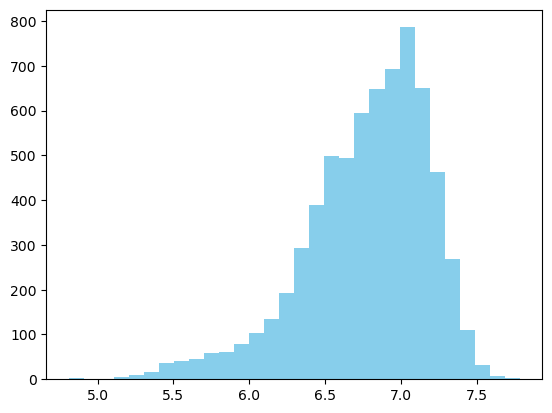

In [3]:
import matplotlib.pyplot as plt
plt.hist(alldata['LAIONScore'],bins=30, color='skyblue') 

In [4]:
#Part3 LoRA
#Part3 LoRA兼容性
import os
import numpy as np
import pandas as pd

path='./dataresult/ImageRatingDataFrameLoRA'
RatingDataFrameFolder = os.listdir(path)
Prompt = pd.read_csv('./PromptsForReviews/LoRAPromptsFromCivitai.csv')
indexlist = list(set(Prompt['index']))
modellist = list(set(Prompt['sd_model_checkpoint']))

def standardize(x):
    return (x-np.mean(x))/np.std(x)
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

for indexname in indexlist:
    indexDataFrame = pd.DataFrame()
    for modelname in modellist:
        tempname = modelname + '-LoRA-' + str(indexname)
        temp = pd.read_csv(os.path.join(path,tempname) +'.csv')
        temp['name'] = tempname
        indexDataFrame = pd.concat([indexDataFrame,temp],axis=0)
    indexDataFrame['StyleLoss']=standardize(indexDataFrame['StyleLoss'])
    indexDataFrame = indexDataFrame.rename(columns={'StyleLoss':'LoRALoss'})
    del indexDataFrame['Unnamed: 0']
    savename = os.path.join('./dataresultbyPrompt/ImageRatingDataFrameLoRA','Prompt-'+str(indexname)+".csv")
    indexDataFrame.to_csv(savename)
#summary
path='./dataresultbyPrompt/ImageRatingDataFrameLoRA'
NormRatingDataFrameFolder = os.listdir(path)
AllNormDataFrame = pd.DataFrame()

for i in NormRatingDataFrameFolder:
    temp = pd.read_csv(os.path.join(path,i))
    AllNormDataFrame = pd.concat([AllNormDataFrame,temp],axis=0)
AllNormDataFrame['Model'] = AllNormDataFrame['name'].apply(lambda x:str(x).split('-')[:-2])
AllNormDataFrame['Model'] = AllNormDataFrame['Model'].apply(lambda x:'-'.join(x))


#drop LoRA image that uses the review model
TargetModel = pd.read_csv('./PromptsForReviews/LoRAUseModel.csv')
TargetModel['name'] = TargetModel['used_sd_model_checkpoint'] + '-LoRA-' +TargetModel['index'].apply(lambda x :str(x))
TargetModel['dropTargetModel'] = True
TargetModel = TargetModel[['name','dropTargetModel']]
AllWithoutTargetModel = pd.merge(AllNormDataFrame,TargetModel,on='name',how='left')
AllWithoutTargetModel = AllWithoutTargetModel[AllWithoutTargetModel['dropTargetModel'] != True]
temp2=AllWithoutTargetModel[['Model','LoRALoss']]
temp2 = temp2.groupby('Model').mean().reset_index()
temp2 = temp2.rename(columns={'LoRALoss':'LoRALoss_NoTM'})
LoRAQualityWithoutTM=temp2

del AllNormDataFrame['name']
temp = AllNormDataFrame.groupby('Model').mean().reset_index()
del temp['Unnamed: 0']
LoRAQuality=temp
LoRAQuality = pd.merge(LoRAQuality,LoRAQualityWithoutTM,on='Model')


C:\Users\BrendanDesktop\AppData\Local\Temp\ipykernel_3748\1717847352.py:55: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = AllNormDataFrame.groupby('Model').mean().reset_index()


In [5]:
#Part2 Style
#Part2 Style兼容性
import os
import numpy as np
import pandas as pd

Prompt = pd.read_csv('./PromptsForReviews/StylePrompts.csv')
indexlist = list(set(Prompt['index']))
modellist = list(set(Prompt['sd_model_checkpoint']))
StyleData = pd.read_csv('./ImageRatingSummary/ImageRatingStyle.csv')

def standardize(x):
    return (x-np.mean(x))/np.std(x)
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


for indexname in indexlist:
    temp = StyleData[StyleData['index'] == indexname].copy()
    temp['StyleLoss']=standardize(temp['StyleLoss']) 
    savename = os.path.join('./dataresultbyPrompt/ImageRatingDataFrameStyle','Prompt-'+str(indexname)+".csv")
    temp.to_csv(savename)

#summary
path='./dataresultbyPrompt/ImageRatingDataFrameStyle'
NormRatingDataFrameFolder = os.listdir(path)
AllNormDataFrame = pd.DataFrame()
for i in NormRatingDataFrameFolder:
    temp = pd.read_csv(os.path.join(path,i))
    AllNormDataFrame = pd.concat([AllNormDataFrame,temp],axis=0)
AllNormDataFrame['Model'] = AllNormDataFrame['name'].apply(lambda x:str(x).split('-')[:-2])
AllNormDataFrame['Model'] = AllNormDataFrame['Model'].apply(lambda x:'-'.join(x))
del AllNormDataFrame['name']
temp = AllNormDataFrame.groupby('Model').mean().reset_index()
del temp['Unnamed: 0'],temp['index']
StyleQuality=temp

C:\Users\BrendanDesktop\AppData\Local\Temp\ipykernel_3748\3754953642.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp = AllNormDataFrame.groupby('Model').mean().reset_index()


In [6]:
temp = pd.merge(ImagePromptQuality,ImageStd,on='Model')
temp = pd.merge(temp,StyleQuality,on='Model')
temp = pd.merge(temp,LoRAQuality,on='Model')

In [6]:
temp.to_csv('./ImageRatingSummary/ModelSummary_Standard.csv')

In [7]:
temp

,Model,Rating,Artifact,ClipScore,LAIONScore,ImageIndex,LAIONScore_Std,StyleLoss,LoRALoss,LoRALoss_NoTM
0,AWPainting 1.1_v1.1.safetensors,-0.281444,0.604700,0.040631,0.583500,16.5,0.306680,0.038155,0.540288,0.540288
1,GhostMix-V2.0-fp16-NoVAE,-0.036123,0.198364,0.262241,0.191307,16.5,0.388465,-0.419657,-0.114531,-0.114531
2,Moyou_v1020.safetensors,-0.636146,0.021177,-1.164639,-0.893277,16.5,0.374577,0.575342,0.280419,0.280419
3,dreamshaper_7.safetensors,0.716444,-0.649532,0.546587,0.361628,16.5,0.388404,-0.020113,-0.110264,-0.110264
4,lyriel_v14.safetensors,0.517458,-0.615607,0.631526,0.132839,16.5,0.433813,0.085033,-0.080010,-0.080010
5,majicmixRealistic_v6.safetensors,-0.482768,0.299762,-0.642076,-0.745622,16.5,0.355439,0.201756,0.023498,0.074825
6,revAnimated_v122.safetensors,0.202579,0.141137,0.325730,0.369625,16.5,0.386477,-0.460516,-0.539401,-0.476623
